In [ ]:
import os
import copy
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from src.utils import eraseWithROI, multiply, multiplyAndWrite

# Change dir + Load files

In [ ]:
%cd drive/My Drive/CV_Proj/CV21_AnnotatedDataset

/content/drive/My Drive/CV_Proj/CV21_AnnotatedDataset


In [ ]:
annot = pd.read_csv("export_data.csv")

# Analyzing labels

In [ ]:
annot

image  xmin  ymin  xmax  ymax                               label
0     img_0001.bmp   302   340   388   414  Chaetomium_Agglomerate_Candidate  
1     img_0001.bmp   552   319   639   375  Chaetomium_Agglomerate_Candidate  
2     img_0001.bmp    56   466    90   507  Stachybotrys_Einzelspore_Candidate
3     img_0001.bmp   852    90   884   123  Stachybotrys_Einzelspore_Candidate
4     img_0001.bmp   876   269   913   305  Chaetomium_Einzelspore_Candidate  
...            ...   ...   ...   ...   ...                                 ...
2142  img_0399.bmp   339   323   372   355  Chaetomium_Einzelspore_Candidate  
2143  img_0400.bmp   444   264   552   335  Chaetomium_Agglomerate_Candidate  
2144  img_0400.bmp   447   497   477   529  Stachybotrys_Einzelspore_Candidate
2145  img_0400.bmp   895   347   930   380  Chaetomium_Einzelspore_Candidate  
2146  img_0400.bmp   390   641   432   687  Chaetomium_Agglomerate_Candidate  

[2147 rows x 6 columns]

In [ ]:
# Query class instances in one image
image_name = 'img_0001.bmp'
annot[annot.image == image_name]

image  xmin  ymin  xmax  ymax                               label
0  img_0001.bmp   302   340   388   414  Chaetomium_Agglomerate_Candidate  
1  img_0001.bmp   552   319   639   375  Chaetomium_Agglomerate_Candidate  
2  img_0001.bmp    56   466    90   507  Stachybotrys_Einzelspore_Candidate
3  img_0001.bmp   852    90   884   123  Stachybotrys_Einzelspore_Candidate
4  img_0001.bmp   876   269   913   305  Chaetomium_Einzelspore_Candidate

# Converting to classification problem

## Example of erasing a class in an image


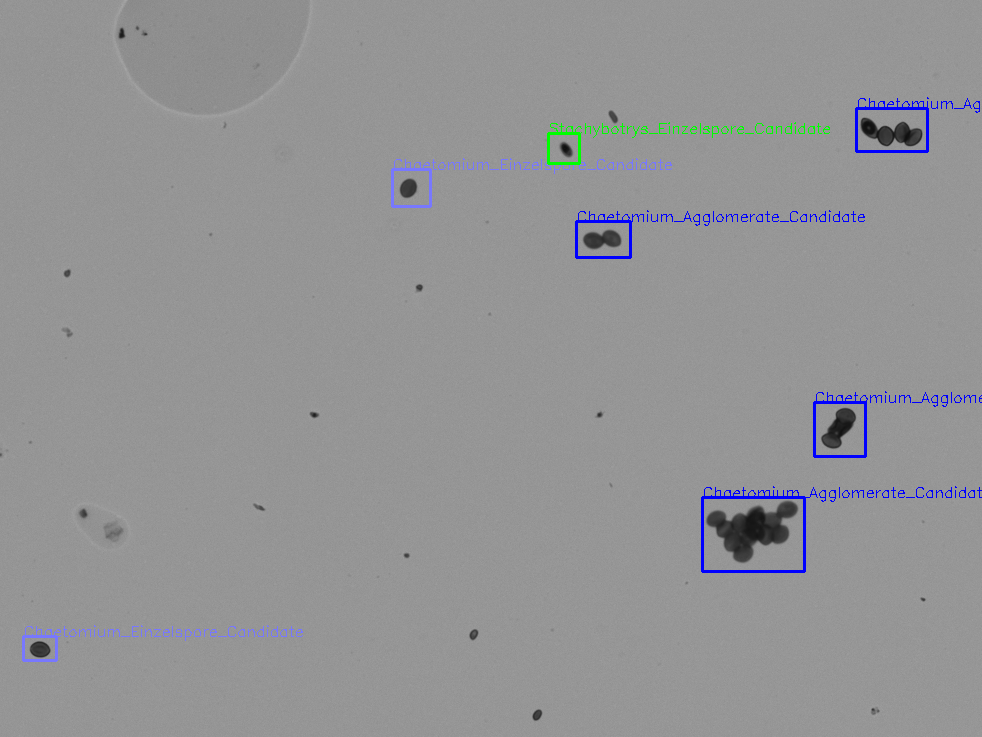

In [ ]:
# Load image
image_name = 'img_0003.bmp'
image = cv.imread(image_name)

# Visualizing classes
color_dict = {'Chaetomium_Agglomerate_Candidate': (255,0,0),
              'Stachybotrys_Einzelspore_Candidate': (0,255,0),
              'Chaetomium_Einzelspore_Candidate': (255,120,120),
              'Stachybotrys_Agglomerate_Candidate': (120,255,120)}

for i in annot[annot.image == image_name].iterrows():
  start_point = (i[1].xmin,i[1].ymin)
  end_point = (i[1].xmax, i[1].ymax)
  color = color_dict[i[1].label.strip()]
  image = cv.rectangle(image, start_point, end_point, color, 2)
  image = cv.putText(image, i[1].label.strip(), start_point, cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

cv2_imshow(image)

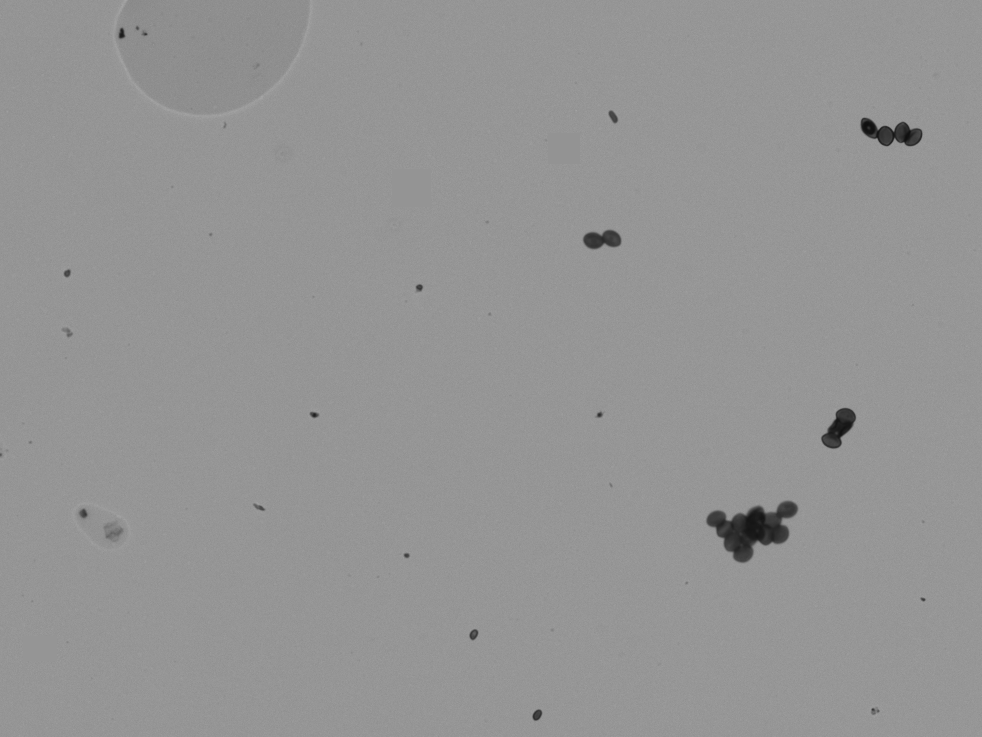

In [ ]:
# Load image
image_name = 'img_0003.bmp'
image = cv.imread(image_name)

# Erase classes except one class
class_of_interest = 'Chaetomium_Agglomerate_Candidate'
for i in annot[annot.image == image_name].iterrows():
  start_point = (i[1].xmin,i[1].ymin)
  end_point = (i[1].xmax, i[1].ymax)
  if i[1].label.strip() != class_of_interest:
    color = (int(image[start_point[1], start_point[0],0]),int(image[start_point[1], start_point[0],1]),int(image[start_point[1], start_point[0],2]))
    image = cv.rectangle(image, start_point, end_point, color , -1)

cv2_imshow(image)

# Augmentation 

## Example of multiplying instances

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


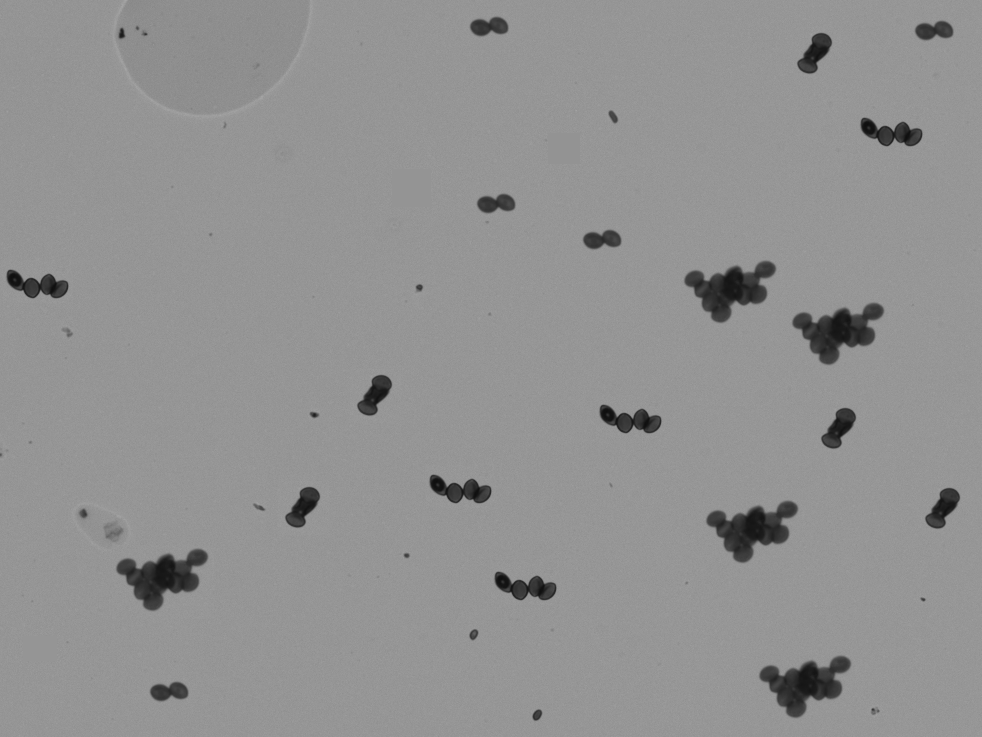

In [ ]:
# Load image
image_name = 'img_0003.bmp'
image = cv.imread(image_name)

# Erase classes except one class
class_of_interest = 'Chaetomium_Agglomerate_Candidate'
for i in annot[annot.image == image_name].iterrows():
  start_point = (i[1].xmin,i[1].ymin)
  end_point = (i[1].xmax, i[1].ymax)
  if i[1].label.strip() != class_of_interest:
    color = (int(image[start_point[1], start_point[0],0]),int(image[start_point[1], start_point[0],1]),int(image[start_point[1], start_point[0],2]))
    image = cv.rectangle(image, start_point, end_point, color , -1)

xmin_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['xmin'].values
xmax_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['xmax'].values
ymin_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['ymin'].values
ymax_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['ymax'].values
knowledge_base = []
for i in range(len(xmin_array)):
  knowledge_base.append((xmin_array[i], xmax_array[i], ymin_array[i], ymax_array[i]))

for i in annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest].iterrows():
  start_point = (i[1].xmin,i[1].ymin)
  end_point = (i[1].xmax, i[1].ymax)
  instance = copy.deepcopy(image)[start_point[1]:end_point[1], start_point[0]:end_point[0]]
  image = multiply(image, instance, knowledge_base, 4)

cv2_imshow(image)

## Example flip

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


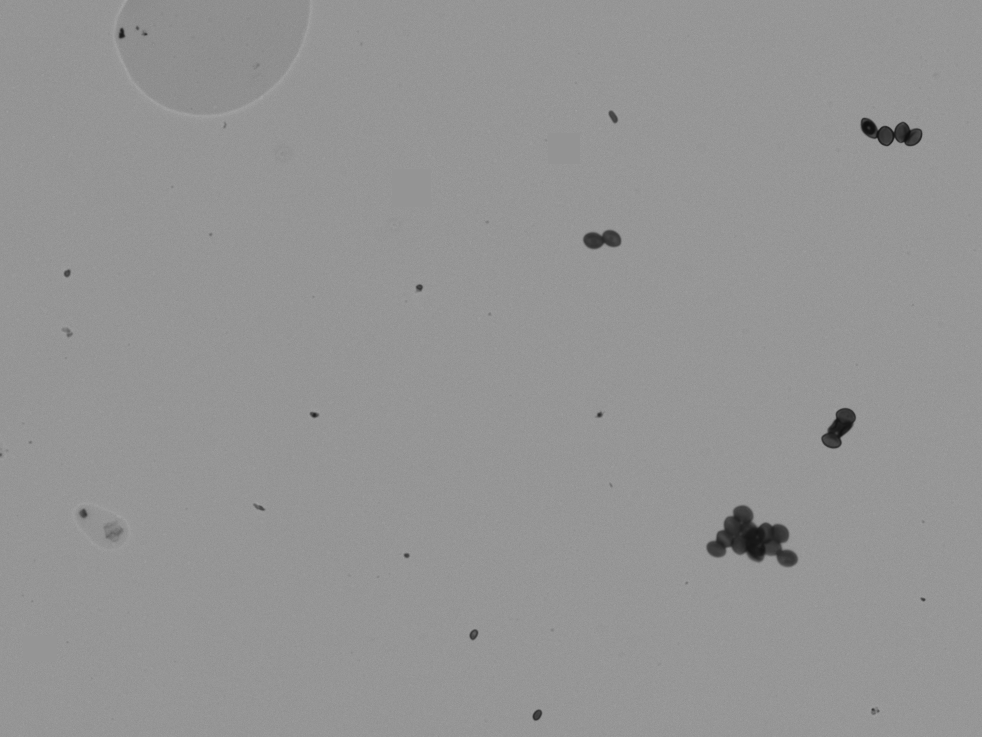

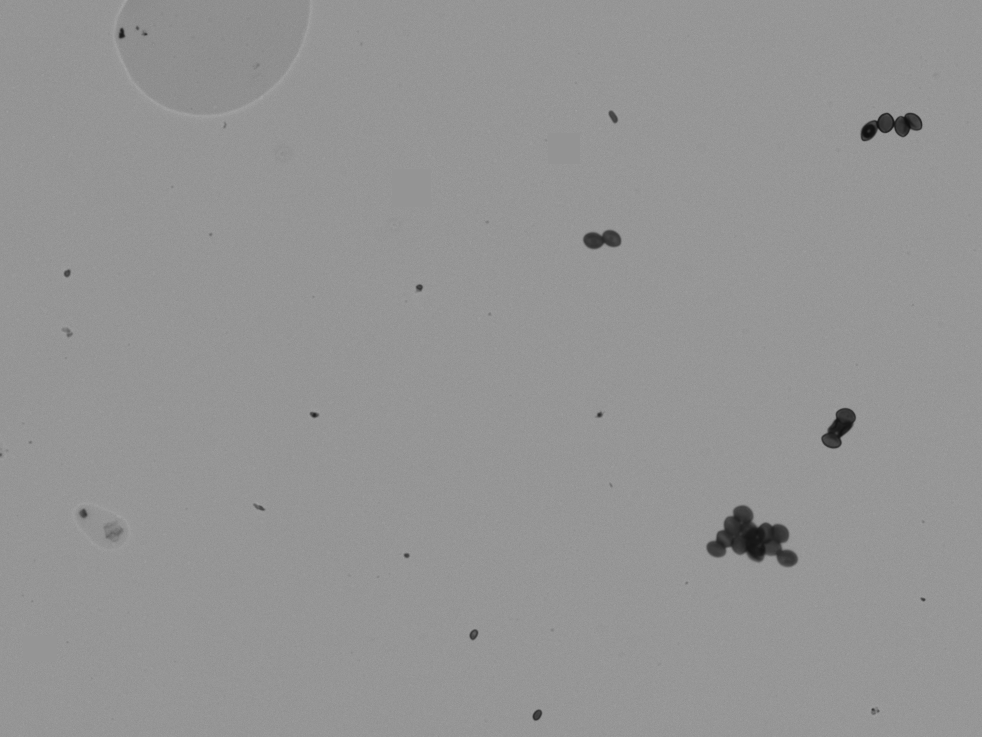

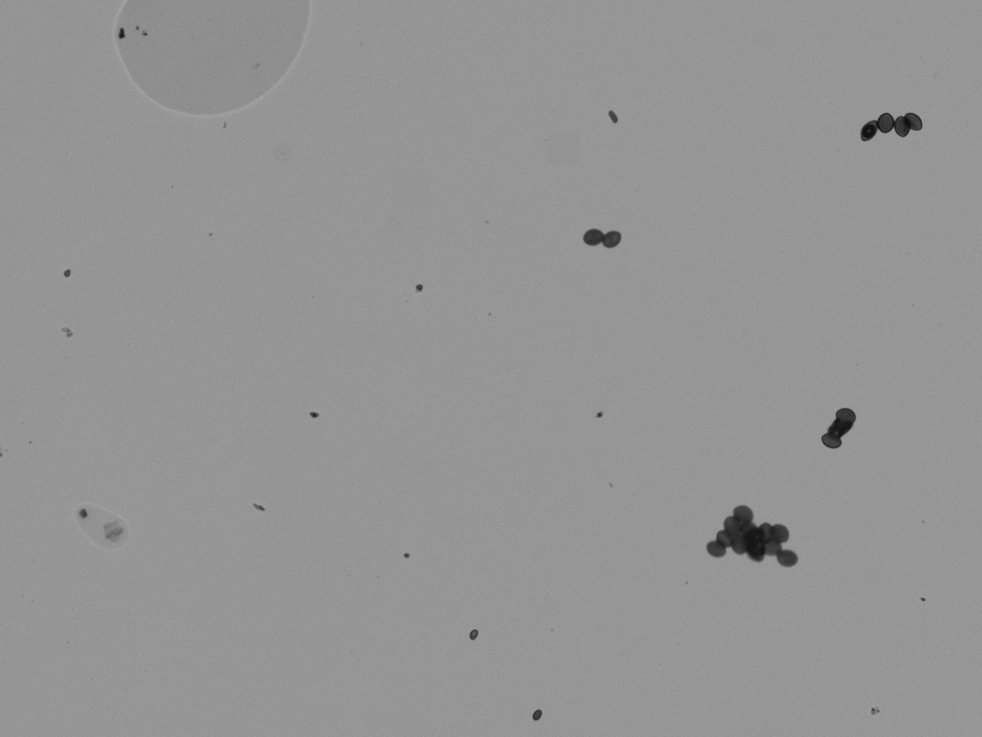

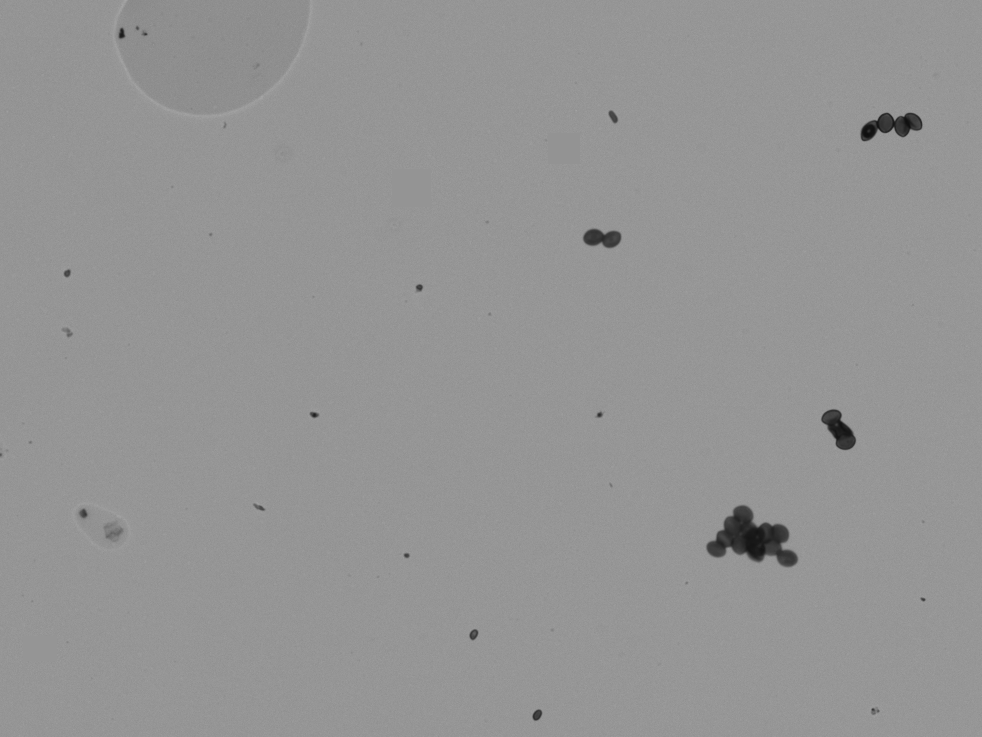

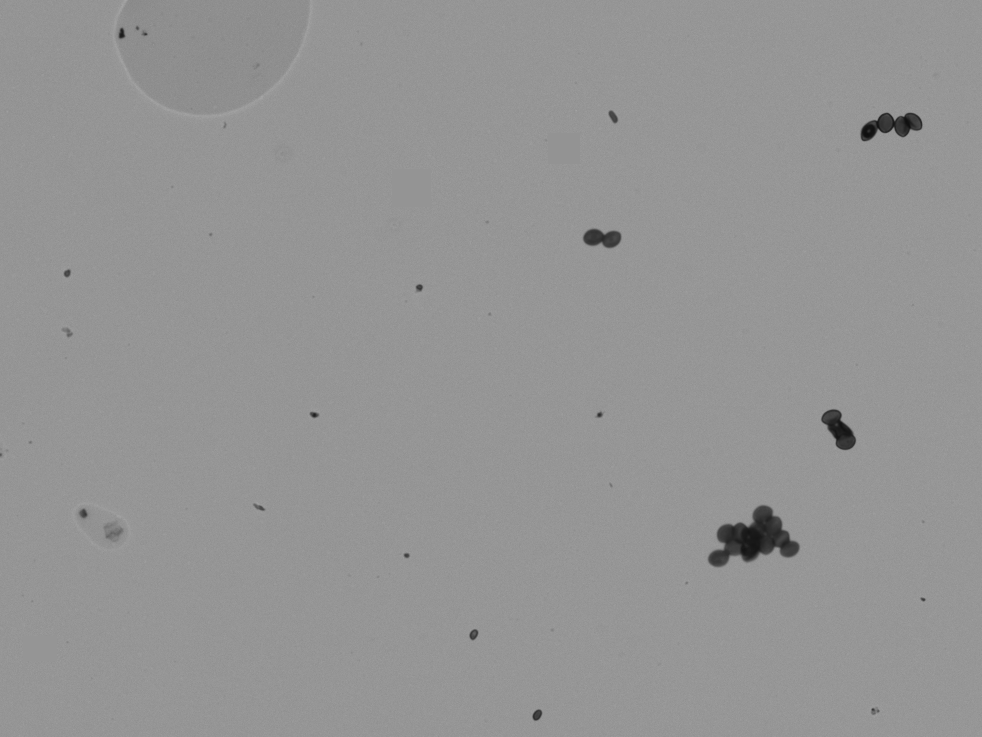

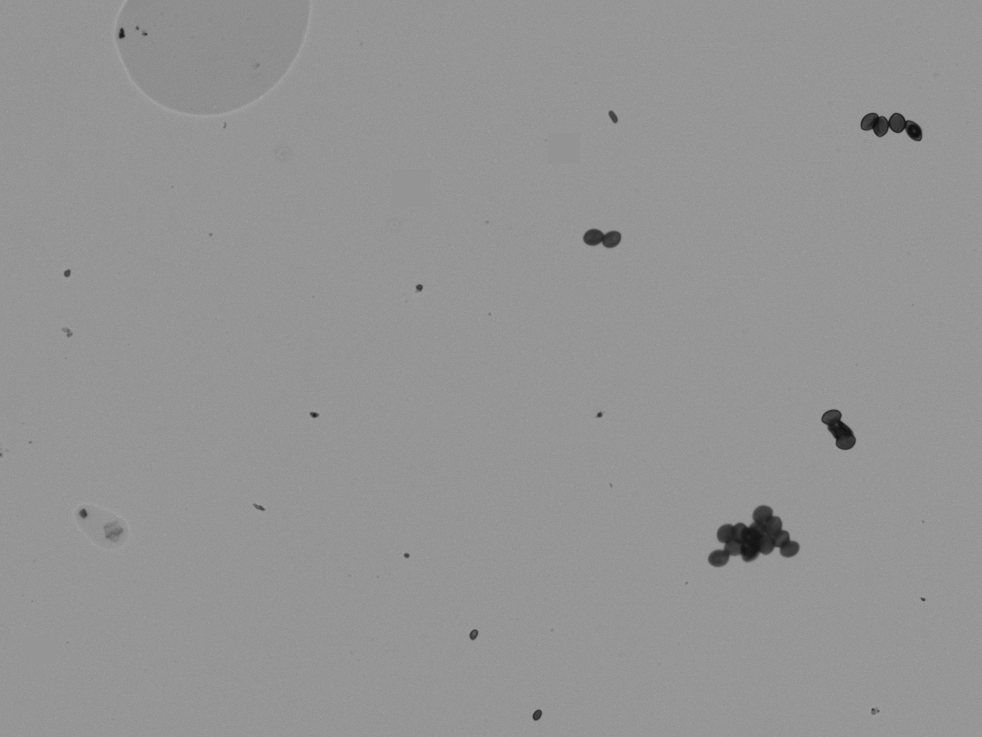

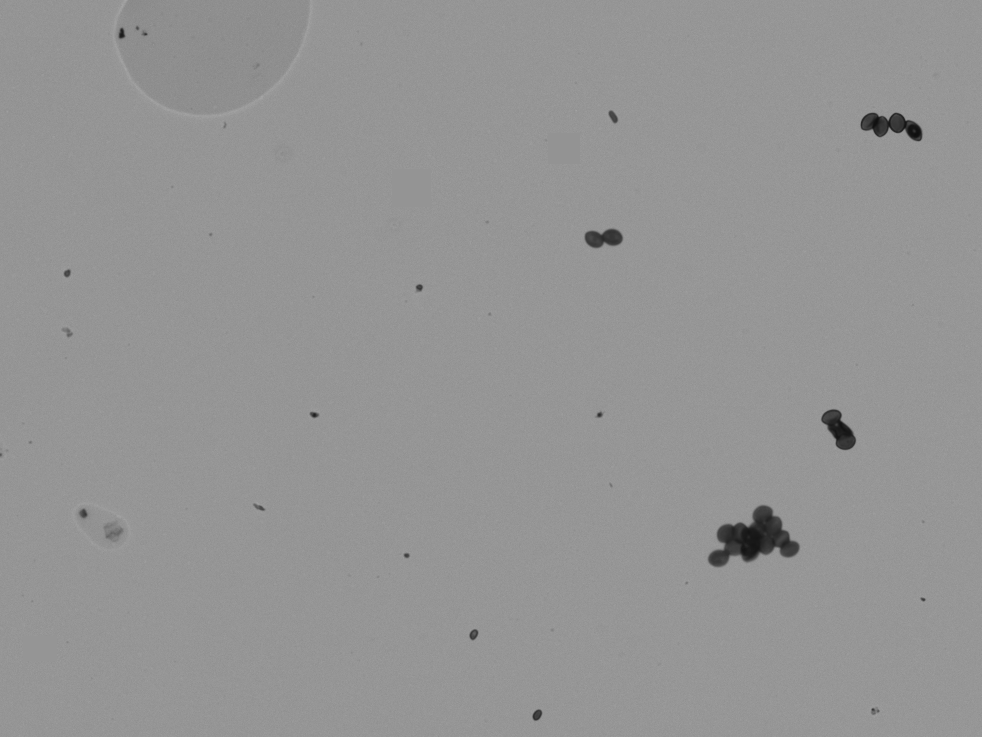

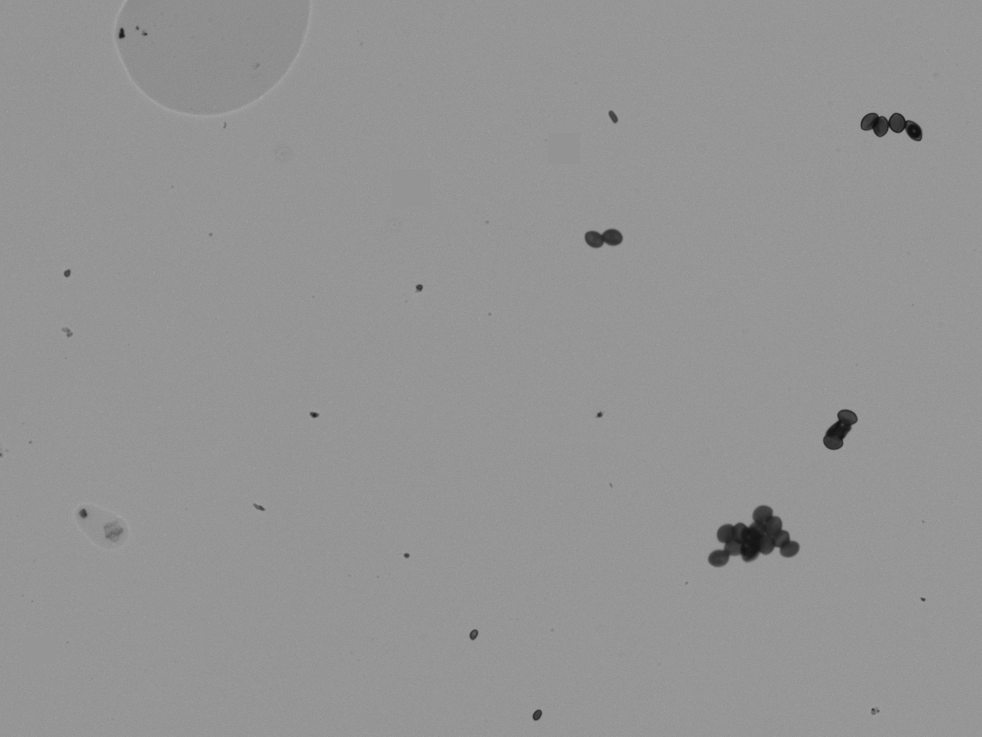

In [ ]:
# Load image
image_name = 'img_0003.bmp'
image = cv.imread(image_name)

class_of_interest = 'Chaetomium_Agglomerate_Candidate'
for i in annot[annot.image == image_name].iterrows():
  start_point = (i[1].xmin,i[1].ymin)
  end_point = (i[1].xmax, i[1].ymax)
  if i[1].label.strip() != class_of_interest:
    color = (int(image[start_point[1], start_point[0],0]),int(image[start_point[1], start_point[0],1]),int(image[start_point[1], start_point[0],2]))
    image = cv.rectangle(image, start_point, end_point, color , -1)

xmin_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['xmin'].values
xmax_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['xmax'].values
ymin_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['ymin'].values
ymax_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['ymax'].values
knowledge_base = []
for i in range(len(xmin_array)):
  knowledge_base.append((xmin_array[i], xmax_array[i], ymin_array[i], ymax_array[i]))

for i in knowledge_base:
  start_point = (i[0], i[2])
  end_point = (i[1], i[3])
  instance = cv.flip(copy.deepcopy(image)[start_point[1]:end_point[1], start_point[0]:end_point[0]], 0)
  image[start_point[1]:end_point[1], start_point[0]:end_point[0]] = instance

  cv2_imshow(image)

for i in knowledge_base:
  start_point = (i[0], i[2])
  end_point = (i[1], i[3])
  instance = cv.flip(copy.deepcopy(image)[start_point[1]:end_point[1], start_point[0]:end_point[0]], 1)
  image[start_point[1]:end_point[1], start_point[0]:end_point[0]] = instance

  cv2_imshow(image)

# Write new classification dataset

In [ ]:
classes_of_interest = ['Chaetomium_Agglomerate_Candidate',
                       'Stachybotrys_Einzelspore_Candidate',
                       'Chaetomium_Einzelspore_Candidate',
                       'Stachybotrys_Agglomerate_Candidate']

# Load labels
annot = pd.read_csv("export_data.csv")

for class_of_interest in classes_of_interest:
  count = 0
  for image_name in os.listdir():
    # Load image
    if image_name.endswith('.bmp'):
      print(image_name)
      image = cv.imread(image_name)
    else:
      continue

    # Erase not-interested classes
    if class_of_interest in np.unique([label.strip() for label in annot[annot.image == image_name].label.values]):
      for i in annot[annot.image == image_name].iterrows():
        start_point = (i[1].xmin,i[1].ymin)
        end_point = (i[1].xmax, i[1].ymax)
        if i[1].label.strip() != class_of_interest:
          image = eraseWithROI(image, start_point, end_point)
    cv.imwrite(f'./augmented_img/{class_of_interest}_{str(count)}.bmp', image)
    count += 1

    # Load knowledge base of all the instances of the class_of_interest
    xmin_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['xmin'].values
    xmax_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['xmax'].values
    ymin_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['ymin'].values
    ymax_array = annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest]['ymax'].values
    knowledge_base = []
    for i in range(len(xmin_array)):
      knowledge_base.append((ymin_array[i], ymax_array[i], xmin_array[i], xmax_array[i]))

    for k in knowledge_base:
      # Flip horizontally
      start_point = (k[0],k[2])
      end_point = (k[1], k[3])
      image_copy = copy.deepcopy(image)
      instance1 = cv.flip(image_copy[start_point[0]:end_point[0], start_point[1]:end_point[1]], 1)
      image_copy[start_point[0]:end_point[0], start_point[1]:end_point[1]] = instance1
      cv.imwrite(f'./augmented_img/{class_of_interest}_{str(count)}.bmp', image_copy)
      count += 1

      # Flip vertically
      image_copy = copy.deepcopy(image)
      instance1 = cv.flip(image_copy[start_point[0]:end_point[0], start_point[1]:end_point[1]], 0)
      image_copy[start_point[0]:end_point[0], start_point[1]:end_point[1]] = instance1
      cv.imwrite(f'./augmented_img/{class_of_interest}_{str(count)}.bmp', image_copy)

    # Multiplying instances
    MULTIPLIER = 4
    for i in annot[annot.image == image_name][annot.label.apply(str.strip)==class_of_interest].iterrows():
      start_point = (i[1].xmin,i[1].ymin)
      end_point = (i[1].xmax, i[1].ymax)
      instance = copy.deepcopy(image)[start_point[1]:end_point[1], start_point[0]:end_point[0]]
      image, knowledge_base, count = multiply(image, instance, knowledge_base, MULTIPLIER, class_of_interest, count)

    print(class_of_interest, count)

img_0001.bmp


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Chaetomium_Agglomerate_Candidate 115
img_0002.bmp
Chaetomium_Agglomerate_Candidate 230
img_0003.bmp
Chaetomium_Agglomerate_Candidate 651
img_0004.bmp
Chaetomium_Agglomerate_Candidate 895
img_0005.bmp
Chaetomium_Agglomerate_Candidate 929
img_0006.bmp
Chaetomium_Agglomerate_Candidate 930
img_0007.bmp
Chaetomium_Agglomerate_Candidate 964
img_0008.bmp
Chaetomium_Agglomerate_Candidate 1079
img_0009.bmp
Chaetomium_Agglomerate_Candidate 1080
img_0011.bmp
Chaetomium_Agglomerate_Candidate 1195
img_0012.bmp
Chaetomium_Agglomerate_Candidate 1196
img_0014.bmp
Chaetomium_Agglomerate_Candidate 1197
img_0013.bmp
Chaetomium_Agglomerate_Candidate 1231
img_0015.bmp
Chaetomium_Agglomerate_Candidate 1265
img_0016.bmp
Chaetomium_Agglomerate_Candidate 1509
img_0017.bmp
Chaetomium_Agglomerate_Candidate 1510
img_0018.bmp
Chaetomium_Agglomerate_Candidate 1544
img_0019.bmp
Chaetomium_Agglomerate_Candidate 1545
img_0020.bmp
Chaetomium_Agglomerate_Candidate 1546
img_0021.bmp
Chaetomium_Agglomerate_Candidate 1580
